In [75]:
import numpy as np
import os
import sys
sys.path.append('../')
import cv2
from utils import load_train_val, load_test, visualize_data_sample
from copy import deepcopy
import sklearn
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
from keras.api.models import Model
from keras.api.layers import Dense, Conv2D, BatchNormalization, LeakyReLU, Flatten, Softmax, Activation, MaxPool2D, Input, Dropout, GlobalAveragePooling2D, ReLU
from keras.api.optimizers import Adam
from keras.api.losses import binary_crossentropy, categorical_crossentropy
from keras.api.utils import to_categorical
import random
import matplotlib.style
import seaborn as sns
from keras.api.applications import ResNet50
import pickle

In [2]:
MULTI_CLASS = True
SHUFFLE = True

In [3]:
(x_train, y_train), (x_val, y_val) = load_train_val(
    datasets_dir='../datasets/Movies',
    multi_class=MULTI_CLASS,
    shuffle=SHUFFLE
)

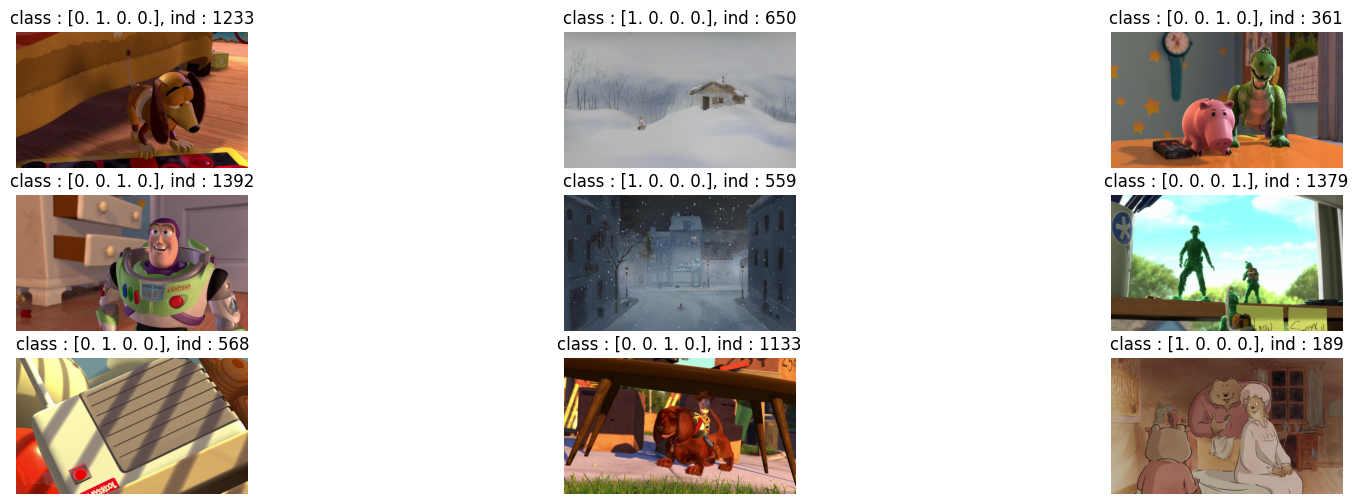

In [4]:
visualize_data_sample(x=x_train, y=y_train, random=True)

In [5]:
(x_test, y_test) = load_test(
    datasets_dir='../datasets/Movies',
    multi_class=MULTI_CLASS,
    shuffle=SHUFFLE
)

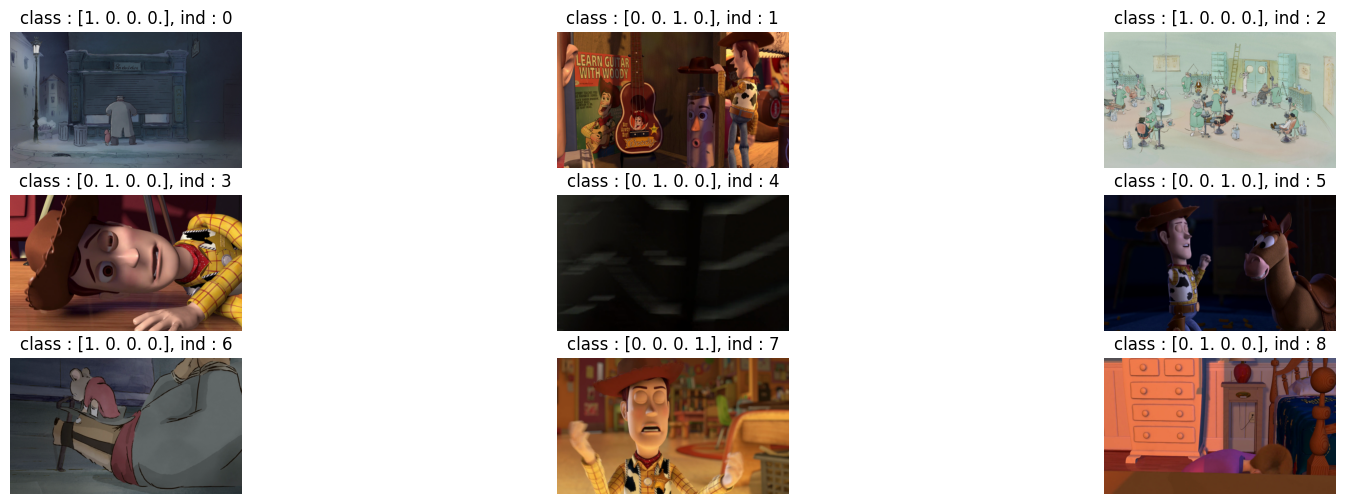

In [6]:
visualize_data_sample(x=x_test, y=y_test)

In [58]:
input = Input((270, 460, 3))

x = Conv2D(filters=4, kernel_size=3, strides=1)(input)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = MaxPool2D()(x)

x = Conv2D(filters=8, kernel_size=3, strides=2)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = MaxPool2D()(x)

x = Conv2D(filters=16, kernel_size=3, strides=2)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = MaxPool2D()(x)

x = Flatten()(x)

x = Dense(16)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
#x = Dropout(rate = 0.5)(x)

x = Dense(4)(x)
output = Activation('softmax')(x)

model_mult = Model(input, output)

In [59]:
model_mult.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 270, 460, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 268, 458, 4)    │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (None, 268, 458, 4)    │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_16 (LeakyReLU)      │ (None, 268, 458, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 134, 229, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 66, 114, 8)     │           296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ (None, 66, 114, 8)     │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_17 (LeakyReLU)      │ (None, 66, 114, 8)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 33, 57, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 16, 28, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_46          │ (None, 16, 28, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_18 (LeakyReLU)      │ (None, 16, 28, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 8, 14, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 1792)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 16)             │        28,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_47          │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_19 (LeakyReLU)      │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 4)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,508 (119.17 KB)

 Trainable params: 30,420 (118.83 KB)

 Non-trainable params: 88 (352.00 B)

In [60]:
opt = Adam(learning_rate=0.0005)
model_mult.compile(optimizer=opt, loss=categorical_crossentropy, metrics=['accuracy'])

In [61]:
history = model_mult.fit(
    x=x_train,
    y=y_train,
    batch_size=4,
    epochs=15,
    validation_data=(x_val, y_val)
)

Epoch 1/15
400/400 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - accuracy: 0.3999 - loss: 1.3248 - val_accuracy: 0.4275 - val_loss: 1.1889
Epoch 2/15
400/400 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - accuracy: 0.5984 - loss: 1.0014 - val_accuracy: 0.6700 - val_loss: 0.8824
Epoch 3/15
400/400 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - accuracy: 0.6368 - loss: 0.9048 - val_accuracy: 0.6325 - val_loss: 0.9488
Epoch 4/15
400/400 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - accuracy: 0.6943 - loss: 0.8104 - val_accuracy: 0.7175 - val_loss: 0.7891
Epoch 5/15
400/400 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.7005 - loss: 0.7783 - val_accuracy: 0.6300 - val_loss: 0.9786
Epoch 6/15
400/400 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - accuracy: 0.7264 - loss: 0.7302 - val_accuracy: 0.7125 - val_loss: 0.7772
Epoch 7/15
400/400 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.7460 - loss: 0.6629 - val_accuracy: 0.7175 - val_loss: 0.7846
Epoch 8/15
400/400 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - accuracy: 0.7805 - loss: 0.5924 - 

In [62]:
evaluation = model_mult.evaluate(x=x_test, y=y_test)

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.5523 - loss: 1.4485


In [78]:
print(str([1,1,2]))

[1, 1, 2]


In [76]:
with open('./models/history_mult.npy', 'wb') as f:
    pickle.dump(history.history, f)

In [80]:
with open('./models/evaluation_mult.npy', 'wb') as f:
    pickle.dump(evaluation, f)

In [70]:
model_mult.save('model_mult.keras')

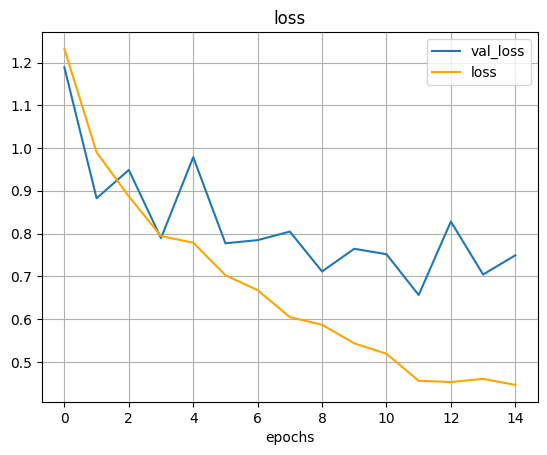

In [63]:
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['loss'], label='loss', color='orange')
plt.xlabel('epochs')
plt.legend()
plt.title('loss')
plt.grid(True)

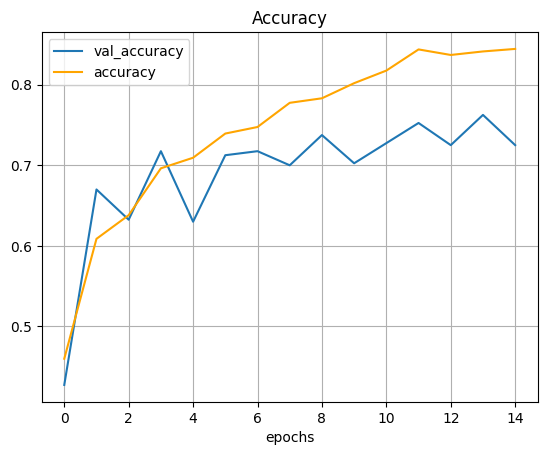

In [64]:
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['accuracy'], label='accuracy', color='orange')
plt.xlabel('epochs')
plt.legend()
plt.title('Accuracy')
plt.grid(True)

In [65]:
y_pred = model_mult.predict(x_test)
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), labels=[0, 1, 2, 3])

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step


Text(50.722222222222214, 0.5, 'True classes')

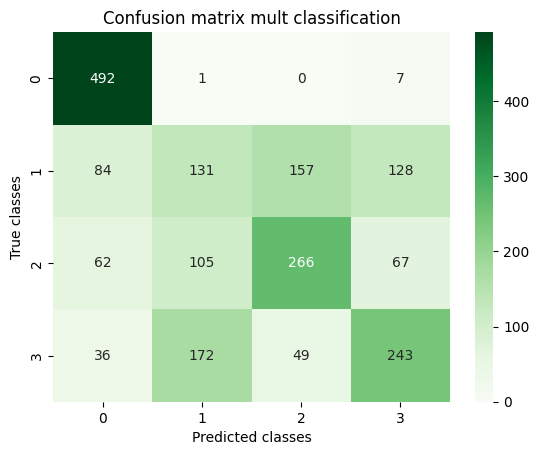

In [66]:
sns.heatmap(cm, annot=True, fmt='g', cmap='Greens'), plt.title('Confusion matrix mult classification')
plt.xlabel('Predicted classes')
plt.ylabel('True classes')

In [48]:
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(270, 460, 3)
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [52]:
for layer in base_model.layers:
    layer.trainable = False

In [57]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.5)(x)

x = Dense(4)(x)
output = Activation('softmax')(x)

model_resnet = Model(base_model.input, output)
opt = Adam(learning_rate=0.0005)
model_resnet.compile(optimizer=opt, loss=categorical_crossentropy, metrics=['accuracy'])

In [58]:
model_resnet.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 270, 460,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 276, 466,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 135, 230,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 135, 230,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 135, 230,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 137, 232,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 68, 115,   │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 68, 115,   │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 68, 115,   │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 68, 115,   │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 68, 115,   │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 68, 115,   │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 68, 115,   │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 68, 115,   │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 68, 115,   │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 68, 115,   │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 68, 115,   │      1,024 │ conv2_block1_3_c

 Total params: 23,851,012 (90.98 MB)

 Trainable params: 263,044 (1.00 MB)

 Non-trainable params: 23,587,968 (89.98 MB)

In [59]:
history_resnet = model_resnet.fit(
    x=x_train,
    y=y_train,
    batch_size=16,
    epochs=15,
    validation_data=(x_val, y_val)
)

Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step - accuracy: 0.4689 - loss: 1.3136 - val_accuracy: 0.2625 - val_loss: 1.6179
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.5879 - loss: 0.9733 - val_accuracy: 0.2525 - val_loss: 1.7619
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - accuracy: 0.6261 - loss: 0.8961 - val_accuracy: 0.2525 - val_loss: 2.4540
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - accuracy: 0.6390 - loss: 0.8472 - val_accuracy: 0.4175 - val_loss: 2.0072
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.6844 - loss: 0.7811 - val_accuracy: 0.2575 - val_loss: 2.1647
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.6922 - loss: 0.7372 - val_accuracy: 0.2525 - val_loss: 5.9804
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.7159 - loss: 0.7050 - val_accuracy: 0.2525 - val_loss: 10.4526
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - accuracy: 0.7531 - loss: 0.6562 - val_acc

KeyboardInterrupt: 